In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# LDA Modeling:

This notebook seeks to extract a number of topics from the reddit /r/WallStreetBets subgroup's posts and comments from Jan 2016 to December 1, 2020. The posts from this period of time will be classified from this set of determined topics, and these topics will also be applied to the last ~ 2.5-3months of collected data going from December 2, 2020 to Feb 2, 2021. The goal is to assign dominant topics to each document, and the results will then be used to model the frequency of these topics over time to see if there is any correlation between topics and movements in GME stock prices/trading metrics.

In [2]:
!pip install gensim==4.0.0

     |████████████████████████████████| 23.9 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [47]:
#!pip install pyLDAvis==2.1.2

In [33]:
import pandas as pd
import numpy as np
import pathlib
import re
from ast import literal_eval
from sklearn.model_selection import train_test_split


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
cwd = pathlib.Path.cwd()
cst_loc = cwd / 'gdrive/My Drive/Capstone_two'

## Model training:

The first step will be to determine the optimal number of topics within the documents. The metrics we shall be using here are 'C_v' for the coherence metric which ranges from -1 to 1 with 1 being the best score. We shall also be testing the models on a held out sample from the training set to measure perplexity: i.e. how well does the model generalize to unseen data. The lower this value the better.

### Create dictionary and corpus:

The data inputs for Gensim's LDA model (multicore model in our case) are a BOW representation of our dataset, and an id2word representation of our data.

For our purposes we shall be doing some additional filtering of the dataset to reduce the occurence of super common words, and incredibly uncommon words with the hopes of getting better topics.

In [42]:
df = pd.read_csv(cst_loc/'training_combined.csv',index_col=0, parse_dates=['dt'], converters={'preprocessed':literal_eval})

In [43]:
df.sort_values(by='dt', ascending=True, inplace=True)

In [ ]:
texts = df['preprocessed'].to_numpy()
#randomly split train and test sets from the whole "training" set
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=0)

id2word = corpora.Dictionary(train_texts)
"""
In an attempt to reduce the dimensionality of the problem a bit more we shall be
putting on more filtering of the preprocessed data to remove words from the corpus
that are both incredibly frequent and infrequent across all documents.
"""
id2word.filter_extremes(no_below=5, no_above=0.75, keep_n=200000)

#for LDA models:
train_corpus = [id2word.doc2bow(text) for text in train_texts]
test_corpus = [id2word.doc2bow(text) for text in test_texts]

## Grid Searching parameters:

For this project I shall first try to find a k for the number of topics which maximizes the coherence score and minimizes perplexity. Then I shall turn my attention to the hyper parameter 'alpha' or the apriori knowledge or assumption of topic distribution per document. 'eta' the apriori distribution of words per topic shall be left as 'auto' and learned throughout training. As I am limited by machine and time capacity--even using colab--I will be leaving other parameters fixed.

In [ ]:
def compute_coh_lda(dictionary, train_corpus, test_corpus, train_texts, test_texts, topics_list, a=['symmetric'], eta='auto'):
    """
    This function will train a number of LDA models using the gensim Multicore
    implementation to make training "faster".

    This will train a model for each of the indicated number of topics and measure
    the coherence using 'u_mass' --also for speed.
    """

    train_coherences = {}
    perplexity = {}
    model_dict = {}

    chunksize=int(len(train_corpus)/2) 

    for num_topics in topics_list:
        for alpha_val in a:

            model = LdaMulticore(
                corpus=train_corpus,
                id2word=dictionary,
                num_topics=num_topics, 
                random_state=42,
                chunksize=chunksize,
                passes=20,
                alpha=alpha_val,
                eta=eta,
                per_word_topics=True,
                workers=7,
                minimum_probability=0.05,
                )
            coherence = CoherenceModel(
                model = model, 
                texts=test_texts,
                corpus=test_corpus,
                dictionary=dictionary, 
                coherence="c_v"
                )

            
            model_dict[alpha_val] = model
            train_coherences[alpha_val] = coherence.get_coherence()
            perplexity[alpha_val] = model.log_perplexity(test_corpus)

    return train_coherences, perplexity, model_dict






### Baseline:

A baseline model assuming k=20 is constructed and evaluated using the randomly held out testing set.

In [ ]:
base_k = [20]
base_coherences,base_perplexity, base_model_dict = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = base_k)

In [ ]:
print(f'For a baseline model assuming {base_k[0]} topics,\n the baseline u_mass coherence score is: {base_coherences[20]}\n with a baseline perplexity of: {base_perplexity[20]}')

For a baseline model assuming 20 topics,
 the baseline u_mass coherence score is: 0.2590689230507923
 with a baseline perplexity of: -7.247312966653731


In [ ]:
k_topics = [50, 80, 110]
k_topics

[50, 80, 110]

In [ ]:
coherence, perplexity, model_dict = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = k_topics)

In [ ]:
coherence

{50: 0.2632986820793089, 80: 0.2626639893707766, 110: 0.2543151797142802}

In [ ]:
coherence_2, perplexity_2, model_dict_2 = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [2,6,10,14])

In [ ]:
coherence_2

{2: 0.2545448274493719,
 6: 0.2582368517990615,
 10: 0.2606039688904821,
 14: 0.256947776977513}

In [ ]:
coherence_3, perplexity_3, model_dict_3 = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [45,55])

In [ ]:
coherence_4, perplexity_4, model_dict_4 = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [60,65,70])

In [ ]:
all_coherences = {**coherence,**coherence_2,**base_coherences,**coherence_3, **coherence_4}


In [ ]:
all_perplexities = {**perplexity,**perplexity_2,**base_perplexity,**perplexity_3, **perplexity_4}

In [ ]:
all_models = {**model_dict,**model_dict_2,**base_model_dict,**model_dict_3, **model_dict_4}

### Determine an optimal k

Iterating over 13 values for presents 65 as being the best value for k befor a steep drop off that continues to decline. This choice was made by selecting a window around 60 of +- 5 and choosing the highest result. In hindsight the difference between 55 and 65 is so little that it may have made more sense to choose that value---see curse of dimensionality.

In [ ]:
def generate_coh_plot(dictionary):
    lists = sorted(dictionary.items())
    x,y = zip(*lists) 
    _, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_facecolor('lightgray')
    ax.plot(x,y,linestyle='--', marker='.', color='purple')
    plt.grid()
    plt.show()

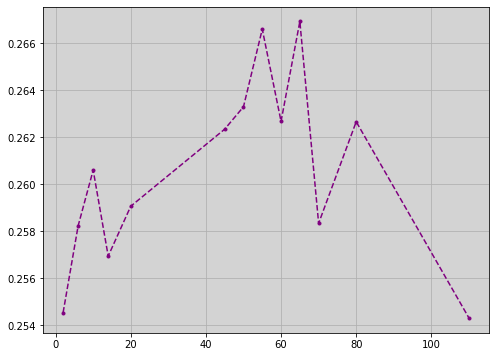

In [ ]:
generate_coh_plot(all_coherences)

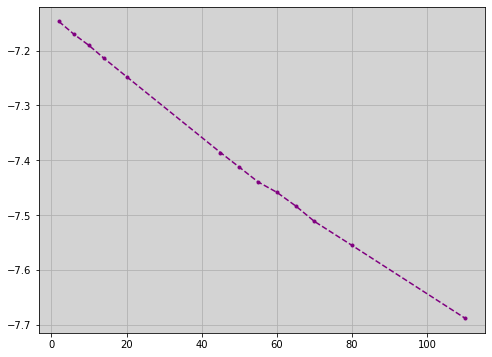

In [ ]:
generate_coh_plot(all_perplexities)

In [ ]:
best_k = [65]

In [ ]:
all_models[65].print_topics()

[(33,
  '0.059*"order" + 0.021*"limit" + 0.020*"buy" + 0.018*"price" + 0.017*"sell" + 0.016*"market" + 0.015*"go" + 0.015*"fill" + 0.013*"call" + 0.011*"get"'),
 (44,
  '0.019*"company" + 0.010*"go" + 0.009*"year" + 0.008*"price" + 0.008*"would" + 0.007*"make" + 0.007*"get" + 0.007*"market" + 0.007*"think" + 0.006*"stock"'),
 (23,
  '0.034*"stock" + 0.023*"click" + 0.023*"earning" + 0.016*"market" + 0.015*"today" + 0.015*"share" + 0.014*"live" + 0.012*"week" + 0.012*"symbol" + 0.010*"report"'),
 (62,
  '0.053*"gun" + 0.010*"buy" + 0.009*"make" + 0.008*"go" + 0.008*"think" + 0.008*"sell" + 0.007*"stock" + 0.007*"get" + 0.006*"day" + 0.006*"people"'),
 (0,
  '0.054*"earning" + 0.029*"call" + 0.026*"go" + 0.016*"buy" + 0.014*"sell" + 0.013*"get" + 0.011*"play" + 0.011*"beat" + 0.011*"hold" + 0.009*"put"'),
 (38,
  '0.023*"go" + 0.016*"buy" + 0.015*"slack" + 0.012*"team" + 0.010*"think" + 0.010*"call" + 0.008*"share" + 0.008*"use" + 0.008*"work" + 0.008*"make"'),
 (5,
  '0.039*"bear" + 0.0

### Tuning alpha:

Now that we have identified a value for K that seems to optimize the coherence of the model we shall try to get a little bit better performance by tuning alpha. Until this point alpha was tuned using a symmetric prior for the topic distribution amongst all of the documents. I will now vary this over a range around a rule of thumb: 50/num_topics to see if there is a better symmetric value of alpha.

In [ ]:
alphas = np.arange(35, 100, 15)/65

In [ ]:
coherence_alpha, perplexity_alpha, model_dict_alpha = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [65], a=alphas)

In [ ]:
coherence_alpha

{0.5384615384615384: 0.26545714497360123,
 0.7692307692307693: 0.26095991122002826,
 1.0: 0.2596206885025917,
 1.2307692307692308: 0.25996666924336315,
 1.4615384615384615: 0.26068961904843263}

In [ ]:
alphas_2 = np.arange(1, 35, 15)/65
alphas_2

array([0.01538462, 0.24615385, 0.47692308])

In [ ]:
coherence_alpha_2, perplexity_alpha_2, model_dict_alpha_2 = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [65], a=alphas_2)

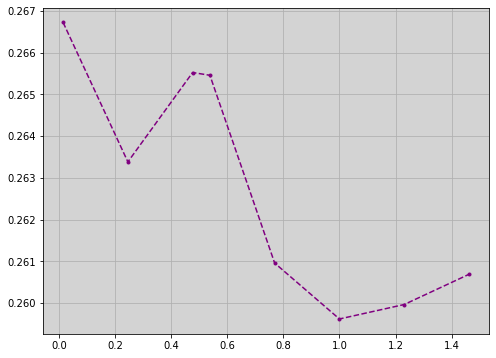

In [ ]:
alpha_coherences = {**coherence_alpha, **coherence_alpha_2}
generate_coh_plot(alpha_coherences)

Through the process of tuning determining the number of topics and alpha values, it would appear that the model had already settled on the optimal parameters--within the limitations of time and hardware. Thus our optimal parameters are the 'auto' value for eta, and the symmetric alpha value of 1/65 for 65 topics. Out of curiosity I would like to try setting alpha to asymmetric to see what the result is.

In [ ]:
coherence_alpha_3, perplexity_alpha_3, model_dict_alpha_3 = compute_coh_lda(dictionary=id2word, train_corpus=train_corpus, test_corpus=test_corpus,train_texts = train_texts, test_texts=test_texts ,topics_list = [65], a=['asymmetric'])

In [ ]:
coherence_alpha_3

{'asymmetric': 0.26769252880504696}

This actually yields the best coherence thus far, with only a slight increase in performance over the earlier best.

In [35]:
with open(cst_loc/'assym_65.pkl', 'rb') as read_file:
    assym_65 = pickle.load(read_file)

with open(cst_loc/'id2wrd.pkl', 'rb') as f:
    dictionary = pickle.load(f)

with open(cst_loc/'trcrps.pkl', 'rb') as g:
    old_train = pickle.load(g)

pyLDAvis.enable_notebook()
initial_vis = pyLDAvis.gensim.prepare(assym_65, old_train, dictionary)
pyLDAvis.display(initial_vis)

Output hidden; open in https://colab.research.google.com to view.

From the preliminary evidence we can see that topic #53 which directly references gamestop and gme can be thought of as a subset of topic #9 which seems to deal with maximizing profit through market analytics.

In [5]:
import pickle

In [ ]:
with open(cst_loc/'assym_65.pkl', 'wb') as write_file:
    pickle.dump(model_dict_alpha_3['asymmetric'], write_file)

In [ ]:
from gensim.models.lsimodel import LsiModel

### Compare LDA to LSI:

Using the same number of topics will generate an LSI model and measure performance between the two models.`

In [ ]:
lsi_65 = LsiModel(corpus=train_corpus,id2word=id2word, num_topics=65)

In [ ]:
lsi_coherence = CoherenceModel(lsi_65,texts=test_texts,
                corpus=test_corpus,
                dictionary=id2word, 
                coherence="c_v" ).get_coherence()

In [205]:
lsi_65.print_topics(num_topics=65, num_words=10)

[(0,
  '0.414*"go" + 0.263*"call" + 0.259*"buy" + 0.235*"get" + 0.235*"put" + 0.161*"sell" + 0.152*"make" + 0.151*"think" + 0.150*"day" + 0.142*"market"'),
 (1,
  '-0.633*"put" + -0.220*"spy" + 0.208*"make" + -0.198*"today" + -0.175*"pump" + 0.143*"face" + 0.131*"want" + 0.129*"give" + 0.127*"stock" + 0.118*"comment"'),
 (2,
  '0.400*"call" + 0.361*"buy" + -0.303*"put" + 0.296*"sell" + 0.190*"earning" + -0.175*"let" + -0.166*"give" + 0.150*"dip" + -0.150*"comment" + -0.146*"make"'),
 (3,
  '-0.367*"let" + 0.230*"tomorrow" + -0.210*"comment" + -0.205*"give" + -0.184*"want" + -0.182*"face" + -0.174*"today" + 0.167*"future" + -0.165*"nice" + 0.163*"market"'),
 (4,
  '-0.857*"oil" + -0.271*"buy" + 0.158*"tomorrow" + -0.097*"barrel" + 0.092*"earning" + 0.092*"market" + -0.090*"pay" + -0.088*"kill" + 0.088*"day" + 0.083*"call"'),
 (5,
  '0.515*"tomorrow" + 0.287*"oil" + -0.234*"week" + -0.196*"next" + -0.192*"pump" + -0.181*"pltr" + 0.171*"future" + -0.170*"share" + -0.170*"weekend" + -0.169

In [ ]:
lsi_coherence

0.25497268989068167

In [ ]:
with open(cst_loc/'lsi_65.pkl','wb') as write_file:
    pickle.dump(lsi_65, write_file)

In [ ]:
with open(cst_loc/'id2wrd.pkl', 'wb') as f:
    pickle.dump(id2word, f)

with open(cst_loc/'trcrps.pkl', 'wb') as g:
    pickle.dump(train_corpus, g)

with open(cst_loc/'tecrps.pkl', 'wb') as h:
    pickle.dump(test_corpus, h)

Based on the increased performance of LDA compared to LSI I will be using LDA as the final model and making the predictions off of that.

In [59]:
with open(cst_loc/'id2wrd.pkl', 'rb') as f:
    id2word = pickle.load(f)

In [60]:
texts = df['preprocessed'].to_numpy()
#randomly split train and test sets from the whole "training" set
train_texts, test_texts = train_test_split(texts, test_size=0.2, random_state=0)


## Update corpus/dictionary and train Final Model:

Here we train a final model using the extended version of the original corpus/dictionary. With this I expect there to be some amount of topic drift, but with the results from the earlier topics that shouldn't be too much of an issue.

In [61]:
id2word.add_documents(test_texts)
whole_corpus = [id2word.doc2bow(doc) for doc in texts]

In [62]:
lda_final = LdaMulticore(
                corpus=whole_corpus,
                id2word=id2word,
                num_topics=65, 
                random_state=42,
                chunksize=int(len(texts)/2),
                passes=20,
                alpha='asymmetric',
                eta='auto',
                per_word_topics=True,
                workers=7,
                minimum_probability=0.05,
                )

In [64]:
with open(cst_loc/'final_lda.pkl', 'wb') as f:
    pickle.dump(lda_final, f) # briefly save newly trained final model

with open(cst_loc/'final_id2wrd.pkl', 'wb') as g:
    pickle.dump(id2word,g)

with open(cst_loc/'final_corpus.pkl','wb') as h:
    pickle.dump(whole_corpus, h)

In [65]:
lda_final.print_topics(num_topics=65, num_words=20)

[(0,
  '0.027*"option" + 0.024*"call" + 0.021*"buy" + 0.020*"sell" + 0.016*"go" + 0.014*"put" + 0.013*"stock" + 0.013*"price" + 0.011*"make" + 0.010*"get" + 0.010*"money" + 0.009*"would" + 0.009*"share" + 0.008*"trade" + 0.007*"time" + 0.007*"lose" + 0.007*"contract" + 0.006*"day" + 0.006*"think" + 0.006*"long"'),
 (1,
  '0.028*"go" + 0.025*"short" + 0.025*"put" + 0.014*"get" + 0.010*"think" + 0.010*"buy" + 0.009*"call" + 0.009*"market" + 0.009*"tomorrow" + 0.008*"future" + 0.008*"open" + 0.008*"know" + 0.008*"sell" + 0.007*"make" + 0.007*"good" + 0.007*"say" + 0.007*"see" + 0.007*"right" + 0.006*"day" + 0.006*"would"'),
 (2,
  '0.045*"market" + 0.019*"go" + 0.015*"year" + 0.014*"earning" + 0.010*"time" + 0.010*"think" + 0.009*"week" + 0.009*"month" + 0.008*"last" + 0.008*"say" + 0.008*"stock" + 0.007*"good" + 0.007*"move" + 0.007*"see" + 0.006*"get" + 0.006*"rate" + 0.006*"recession" + 0.006*"gain" + 0.006*"call" + 0.006*"buy"'),
 (3,
  '0.052*"post" + 0.032*"tendie" + 0.020*"retard" 

Indeed we see some topic drift:

There are fewer topics that directly reference gamestop, and fewer that also happen to reference shorts. However, #22 directly references both gme and short but both of these values are much further down the list indicating that there is less weight given to those words in that topic.

There is no pyLDAvis for this, as there is some thing going on where not all probabilities sum to 1.

### Make predictions on topics and assign to documents:


In [71]:
def classify_doc_topic(model, corpus):
    assigned_topics = []
    topic_pcnts = []

    for i, row in enumerate(model[corpus]):
        topic_no, topic_pcnt = sorted(row[0], key = lambda x: (x[1]), reverse=True)[0]
        assigned_topics.extend([topic_no])
        topic_pcnts.extend([topic_pcnt])
    return assigned_topics, topic_pcnts

In [74]:
topic_numbers, topic_weight = classify_doc_topic(lda_final, whole_corpus)

In [ ]:
df['primary_topic'] = topic_numbers
df['topic_pcnt'] = topic_weight

### Measure the coherence of the model and the perplexity of the model to the validation data:

In [67]:
df_validation = pd.read_csv(cst_loc/'validation_combined.csv',index_col=0, parse_dates=['dt'], converters={'preprocessed':literal_eval})
df_validation.sort_values(by='dt', ascending=True, inplace=True)


In [68]:
validation_texts = df_validation['preprocessed'].to_numpy()
validation_corpus = [id2word.doc2bow(doc) for doc in validation_texts]

In [66]:
final_model_coherence = CoherenceModel(model=lda_final, texts=texts, corpus=id2word, processes=7, coherence='c_v').get_coherence()

In [69]:
final_model_coherence

0.2744659762367004

In [70]:
lda_final.log_perplexity(validation_corpus)

-7.883718404378337

The coherence score for this final model is higher than in all cases tested thus far. We do see a slight increase in the perplexity measured on the data that has been held out from the very beginning. The next step is to take a closer look at the determined topics to see if a general context can be constructed from the top ~20 words.

### Predict topics for validation set:

In [72]:
topic_dict = {}
for i in range(65):
    topic_20 = ", ".join([w for w,p in lda_final.show_topic(i, topn=20)])
    topic_dict[i] = topic_20

In [73]:
topic_dict

{0: 'option, call, buy, sell, go, put, stock, price, make, get, money, would, share, trade, time, lose, contract, day, think, long',
 1: 'go, short, put, get, think, buy, call, market, tomorrow, future, open, know, sell, make, good, say, see, right, day, would',
 2: 'market, go, year, earning, time, think, week, month, last, say, stock, good, move, see, get, rate, recession, gain, call, buy',
 3: 'post, tendie, retard, autist, get, first, guy, buy, make, go, good, gain, time, autistic, stock, tell, new, day, say, update',
 4: 'go, buy, call, earning, get, sell, think, good, put, make, hold, money, week, see, share, play, look, stock, still, know',
 5: 'market, go, get, put, think, look, time, spy, week, good, call, say, make, see, buy, day, thank, would, money, close',
 6: 'call, put, spy, buy, crash, go, loss, get, money, make, time, stock, market, think, good, retard, lose, look, sell, say',
 7: 'cancel, get, buy, go, put, volume, money, make, think, see, time, membership, know, bag,

The intelligible topics:

    - 0: long/short term trading advice
    - 9: Trump tax plan
    - 18: 2020 election
    - 22: increase gme price/short squeeze
    - 25: market trends bear/bull
    - 27: legalization of Marijuana
    - 32: trading with robinhood
    - 34: price per barrel of oil
    - 37: covid vaccinations
    - 48: corn
    - 55: spacex mining asteroids, batteries
    - 58: quarterly earnings reports


In [ ]:
validation_topics, validation_pcnts = classify_doc_topic(lda_final, validation_corpus)

In [ ]:
df_validation['primary_topic'] = validation_topics
df_validation['topic_pcnt'] = validation_pcnts

In [ ]:
df_validation.to_pickle(cst_loc/'validation_labeled.pkl')


In [ ]:
df.to_pickle(cst_loc/'training_labeled.pkl')

I haven't quite been able to figure out what is going on but there is something going on with the pandas version and that seems to be related to pyLDAvis, as this is the only difference between now and the preprocessing step.

The code below is on a fresh VM with an older version of pyLDAvis installed. This resulted in no errors.

In [77]:
df_tr = pd.read_pickle(cst_loc/'training_labeled.pkl')

In [96]:
df_tr.to_csv(cst_loc/'training_labeled.csv')

In [98]:
df_tr[(df_tr.primary_topic == 22)]

,id,preprocessed,preprocessed_str,sentiment,objective,dt,text_len,num_comments,primary_topic,topic_pcnt
0,3z02a1,"[time, share, secret, money, make, little, bnhlf]",time share secret money make little bnhlf,-0.293750,0.600000,2016-01-01,7,0,22,0.667746
309,45dp5b,"[spy, long, put, put, long, option, big, compa...",spy long put put long option big company spy y...,0.008364,0.526592,2016-02-12,183,15,22,0.330604
531,4a2u5n,"[make, card, guy, day, get, ban, share]",make card guy day get ban share,0.000000,0.000000,2016-03-12,7,0,22,0.876832
794,4e5sdx,"[interesting, stuff, week, sector, current, pr...",interesting stuff week sector current price ca...,0.068750,0.443750,2016-04-10,66,7,22,0.420758
800,4eau5t,"[stock, seem, brain, buck, last, month, pull, ...",stock seem brain buck last month pull thinking...,0.000000,0.066667,2016-04-11,16,0,22,0.942032
...,...,...,...,...,...,...,...,...,...,...
54922,k4k5yr,"[fingers_splayed, gme, autist, pump]",fingers_splayed gme autist pump,0.000000,0.000000,2020-12-01,4,0,22,0.379318
54898,k4endd,"[ready, throw, tomorrow, play, call, share, gm...",ready throw tomorrow play call share gme post ...,-0.166667,0.411111,2020-12-01,12,2,22,0.372271
54906,k4hf80,"[launch, rocket, guy, be, buy, want, launch, o...",launch rocket guy be buy want launch open go m...,0.193750,0.562500,2020-12-01,15,1,22,0.746458
54913,k4ivqe,"[sell, crsr, brqs, share, buy, gme]",sell crsr brqs share buy gme,0.000000,0.000000,2020-12-01,6,0,22,0.835782


In [76]:
df_va = pd.read_pickle(cst_loc/'validation_labeled.pkl')

In [97]:
df_va.to_csv(cst_loc/'validation_labeled.csv')

In [34]:
df_va[(df_va.primary_topic ==22) & (df_va.topic_pcnt > .7)] ## this gives some interesting results

,id,preprocessed,preprocessed_str,sentiment,objective,dt,text_len,num_comments,primary_topic,topic_pcnt
79,k5hes9,"[pltr, rocket, rocket, rocket, rocket]",pltr rocket rocket rocket rocket,0.000000,0.000000,2020-12-02,5,0,22,0.835783
5,k4y1xh,"[imminent, short, squeeze, imminent, tendie, i...",imminent short squeeze imminent tendie imminen...,0.053951,0.461984,2020-12-02,7037,207,22,0.981852
42,k5adl1,"[moon, rocket, rocket, rocket, rocket, rocket,...",moon rocket rocket rocket rocket rocket rocket...,0.000000,0.000000,2020-12-02,16,0,22,0.942041
39,k5aa2w,"[much, honest, work, moon, rocket, rocket, roc...",much honest work moon rocket rocket rocket,0.600000,0.900000,2020-12-02,7,0,22,0.708347
141,k604j4,"[leave, investment, behestment, fast, forward,...",leave investment behestment fast forward year ...,0.150000,0.311111,2020-12-03,23,0,22,0.823882
...,...,...,...,...,...,...,...,...,...,...
27123,la1qgp,"[rocket, rocket, rocket, rocket]",rocket rocket rocket rocket,0.000000,0.000000,2021-02-01,4,0,22,0.802940
27095,la1gi5,"[early, shopping, man, hold, new, moon, face, ...",early shopping man hold new moon face face roc...,0.118182,0.377273,2021-02-01,11,0,22,0.777115
27173,la2a1x,"[rocket, rocket, rocket]",rocket rocket rocket,0.000000,0.000000,2021-02-01,3,0,22,0.753675
27189,la2fa9,"[rocket, rocket, rocket, datum, moon]",rocket rocket rocket datum moon,0.000000,0.000000,2021-02-01,5,0,22,0.835775


## Final remarks